# Model 2 - RNN using kinematic features only

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

sys.path.append('../dtu-deep-learning-project/src/')
from data_utils import *
clear_output(wait=False)

In [2]:
torch.cuda.set_device(0)
torch.cuda.requires_grad = True

### Load train, validation and test data

In [3]:
classification_test_performance = []
training_time = []
prediction_time = []
number_list=np.arange(0,12).tolist()
random.Random(17).shuffle(number_list)
print(number_list)
#number_list = [10, 4, 6, 8, 1, 9, 3, 7, 5, 0, 2, 11]

[10, 3, 0, 2, 7, 11, 1, 9, 5, 4, 6, 8]


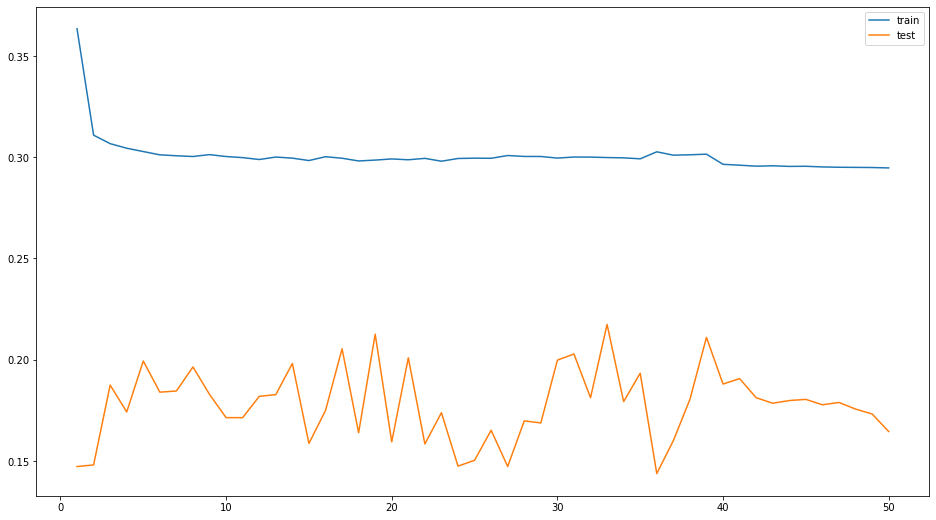

average epoch duration 4.709688167572022
stdev epoch duration 0.447245341983202
Training lasted 235.48440837860107
test
11
              precision    recall  f1-score   support

      Motion       0.92      0.97      0.94     12727
        Stop       0.77      0.48      0.59      2211

    accuracy                           0.90     14938
   macro avg       0.84      0.73      0.77     14938
weighted avg       0.89      0.90      0.89     14938

Training time 2849.318203687668
Prediction time 13.897757291793823


In [4]:
for k in range(0,12):
    ############################################################################
    #Train/Test Split of the k^th fold
    ############################################################################
    print(f'Train partition: {number_list[0:k]+number_list[k+1:]}')
    print(f'Test partition: {number_list[k]}')
    user_train = train = number_list[0:k]+number_list[k+1:]
    user_test = test = [number_list[k]]
    
    ############################################################################
    ### Set time interval and speed cut off
    ############################################################################
    seq_cutoff_speed = 45
    seq_cutoff_time = 60
    filter_seq = 5
    
    ############################################################################
    ### Load data
    ############################################################################
    data_train = pd.concat([create_data_frame(*load_user_data(user,load_web_mercator = True), segmentation=True, seq_cutoff_time = seq_cutoff_time, seq_cutoff_speed = seq_cutoff_speed) for user in user_train]).reset_index(drop=True)
    data_test = pd.concat([create_data_frame(*load_user_data(user,load_web_mercator = True), segmentation=True, seq_cutoff_time = seq_cutoff_time, seq_cutoff_speed = seq_cutoff_speed) for user in user_test]).reset_index(drop=True)
    
    
    ############################################################################
    #### Define Dataset
    #### We implement our own Tensor Dataset in order to be able to do fast lookup of sequences and images.
    ############################################################################
    class TensorDataset(torch.utils.data.Dataset):

        def __init__(self, df, filter_seq=filter_seq):
            self.seq = np.stack([np.roll(df[['delta_d', 'bearing']].values, i, axis = 0) for i in range(filter_seq, -1, -1)], axis = 1)
            self.seq = self.seq[df['segment_ix'] >= filter_seq]

            self.labels = df[df['segment_ix'] >= filter_seq]['label'].values        
            self.user_id = df[df['segment_ix'] >= filter_seq]['user'].values
            tod = df[df['segment_ix'] >= filter_seq]['tod'].values
            self.tod_one_hot = np.eye(5)[tod]

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, key):
            return self.seq[key], self.tod_one_hot[key], self.labels[key]   
    
    ############################################################################
    ### Hyper Parameters
    # Network Parameters
    ############################################################################
    IMG_INPUT_H_W = 9, 9
    IMG_INPUT_C = 11
    TOD_INPUT_DIM = 6

    SEQ_LENGTH = filter_seq+1
    SEQ_FEATURES = 2
    TOD_INPUT_DIM = 5
    RNN_HIDDEN_DIM = 4
    RNN_NUM_LAYERS = 2
    RNN_BIDIRECT = True
    FC_HIDDEN_DIM = 512
    DROPOUT_PROP = 0.45

    NUM_CLASSES = 2

    ############################################################################
    # Training Parameters
    ############################################################################
    NUM_EPOCH = 50
    BATCH_SIZE = 12000
    LEARNING_RATE = 0.1
    LEARNING_DECAY_FACTOR = 0.1
    LEARNING_DECAY_EPOCHS = [40]
    
    ############################################################################
    #### Define Data Loaders
    ############################################################################
    train_dataloader = torch.utils.data.DataLoader(TensorDataset(data_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
    test_dataloader = torch.utils.data.DataLoader(TensorDataset(data_test), batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
    
    ############################################################################
    #### Define some utility functions for building and running the network
    ############################################################################
    def adjust_lr(optimizer, epoch):
        number_decay_points_passed = np.sum(epoch >= np.array(LEARNING_DECAY_EPOCHS))
        lr = LEARNING_RATE * (LEARNING_DECAY_FACTOR ** number_decay_points_passed)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        return lr

    class SelectItem(nn.Module):
        def __init__(self, item_index):
            super(SelectItem, self).__init__()
            self._name = 'selectitem'
            self.item_index = item_index

        def forward(self, inputs):
            return inputs[self.item_index]
    
    
    ############################################################################
    ### Define network for Convolutional neural network (CNN) using only geo-spatial features
    ############################################################################
    class CnnNet(nn.Module):

        def __init__(self):
            super(CnnNet, self).__init__()

            rnn_output_dim = SEQ_LENGTH*RNN_HIDDEN_DIM
            if RNN_BIDIRECT:
                rnn_output_dim *= 2

            self.rnn_layer = nn.Sequential(
                nn.GRU(SEQ_FEATURES, RNN_HIDDEN_DIM, RNN_NUM_LAYERS, batch_first=True, bidirectional=RNN_BIDIRECT),
                SelectItem(0),
                nn.Flatten(start_dim=1),
                nn.BatchNorm1d(rnn_output_dim),
                nn.ReLU(),
                nn.Dropout(DROPOUT_PROP)
            )
            self.fc_layer = nn.Sequential(
                nn.Linear(TOD_INPUT_DIM + rnn_output_dim, FC_HIDDEN_DIM),
                nn.BatchNorm1d(FC_HIDDEN_DIM),
                nn.ReLU(),
                nn.Dropout(DROPOUT_PROP),
                nn.Linear(FC_HIDDEN_DIM, FC_HIDDEN_DIM//5),
                nn.BatchNorm1d(FC_HIDDEN_DIM//5),
                nn.ReLU(),
                nn.Dropout(DROPOUT_PROP),
                nn.Linear(FC_HIDDEN_DIM//5, NUM_CLASSES),
                #nn.BatchNorm1d(NUM_CLASSES),
                #nn.ReLU(),
                #nn.Dropout(DROPOUT_PROP)
            )
            #print(CNN_HIDDEN_DIM_2 * h * w + TOD_INPUT_DIM + rnn_output_dim)      

        def forward(self, X_seq, X_tod):
            out_seq = self.rnn_layer(X_seq)
            #print(f'5     {X_seq.shape}')
            out = torch.cat([out_seq, X_tod], dim=1)
            #print(f'6     {out.shape}')
            out = self.fc_layer(out)

            return out

    ############################################################################
    #### Define class weights due to large class im-balance
    ############################################################################
    class_weights = [(data_train['label'] == 0).sum()/(data_train['label'] == x).sum() for x in range(NUM_CLASSES)]
    
    
    ############################################################################
    #### Define model, optimizer and loss
    ############################################################################
    device = torch.device('cuda:0') # PyTorch v0.4.0
    model = CnnNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-10)
    criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights).to(device))
    ##################
    
    
    ############################################################################
    #### Dictionary to handle training and test loops
    ############################################################################
    phases = {
        'train': {
            'dataloader': train_dataloader,
            'is_training': True,
        },
        'test': {
            'dataloader': test_dataloader,
            'is_training': False,
        }
    }
    
    ############################################################################
    #### Set the list to store computation time at each epoch
    epochComputationTime =  []
    ############################################################################
    
    
    ############################################################################
    ### Train loop
    ############################################################################
    for epoch in range(1, NUM_EPOCH + 1):

        for phase_name, phase in phases.items():
            epoach_loss = 0.0

            phase_is_training = phase['is_training']
            phase_dataloader = phase['dataloader']
            model.train(phase_is_training)

            ############################################################################
            # Ajust and save the learning rate in the phase dict
            ############################################################################
            if phase_is_training:
                startEpoch = time.time()
                lr = adjust_lr(optimizer, epoch)
                phase.setdefault('lr', []).append(lr)

            ############################################################################
            # Iterate over each bath in the phase
            ############################################################################
            for i, batch in enumerate(phase_dataloader, 1):
                #print(i)
                #print(batch[0].shape)
                X_seq, X_tod, y = batch


                X_seq = X_seq.to(device, dtype=torch.float)
                X_tod = X_tod.to(device, dtype=torch.float)
                y = y.to(device, dtype=torch.int64)

                with torch.set_grad_enabled(phase_is_training):
                    out = model(X_seq, X_tod)
                    loss = criterion(out, y)

                if phase_is_training:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_value_(model.parameters(), 0.5)
                    optimizer.step()


                epoach_loss += loss.item()

            ############################################################################
            # Save the loss for the epoch in the phase dict
            ############################################################################
            phase.setdefault('loss', []).append(epoach_loss/i)
            if phase_is_training:
                endEpoch = time.time()
                epochComputationTime.append(endEpoch-startEpoch)
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize = (16, 9))
        #ax.set_yscale('log')

        for phase_name, phase in phases.items():
            ax.plot(np.arange(1, epoch + 1), phase['loss'], label = phase_name)        

        ax.legend()
        plt.show();            
        print(f'average epoch duration {np.mean(epochComputationTime)}')
        print(f'stdev epoch duration {np.std(epochComputationTime)}')
        print(f'Training lasted {np.sum(epochComputationTime)}')
    
    ############################################################################
    #Append training-time of the loop
    ############################################################################
    training_time.append(np.sum(epochComputationTime))
    
    
    ############################################################################
    ### Test prediction loop
    ############################################################################
    for phase_name, phase in phases.items():
        if phase['is_training']: 
            continue

        phase_dataloader = phase['dataloader']
        phase['predicted'] = []
        phase['true'] = []
        
        startPred = time.time()
        for i, batch in enumerate(phase_dataloader, 1):
            X_seq, X_tod, y = batch

            phase['true'].extend(list(y.numpy()))

            X_seq = X_seq.to(device, dtype=torch.float)
            X_tod = X_tod.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.float)

            with torch.no_grad():
                out = model(X_seq, X_tod)
                probability, predicted = torch.max(out, 1)

            phase['predicted'].extend(list(predicted.cpu().numpy()))
        endPred = time.time()
        prediction_time.append(endPred-startPred)    
    for phase_name, phase in phases.items():
        if phase['is_training']: 
            continue

        print(phase_name)
        cr=classification_report(phase['true'], phase['predicted'], target_names = ['Motion','Stop'],output_dict=True)
        classification_test_performance.append(cr)
        print(k)
        #print(cr)
        print(classification_report(phase['true'], phase['predicted'], target_names = ['Motion','Stop'],output_dict=False))
        print(f'Training time {np.sum(training_time)}')
        print(f'Prediction time {np.sum(prediction_time)}')

In [5]:
np.save('classification_test_performanceRNN12fold50Sh.npy',classification_test_performance)
F1_macro_AVG = []
F1_weighted_AVG = []
for cr in classification_test_performance:
    F1_macro_AVG.append(cr['macro avg']['f1-score'])
    F1_weighted_AVG.append(cr['weighted avg']['f1-score'])
supports = [cf['macro avg']['support'] for cf in classification_test_performance]
print(f'MEAN = {np.mean(F1_macro_AVG)}, WEIGHTED AVG = {np.sum([F1_macro_AVG[i]*supports[i] for i in range(0,len(F1_macro_AVG))])/(np.sum(supports))}, STDEV = {np.std(F1_macro_AVG)}')
print(f'MEAN = {np.mean(F1_weighted_AVG)}, WEIGHTED AVG = {np.sum([F1_weighted_AVG[i]*supports[i] for i in range(0,len(F1_weighted_AVG))])/(np.sum(supports))}, STDEV = {np.std(F1_weighted_AVG)}')

MEAN = 0.760570647270332, WEIGHTED AVG = 0.8516004112371487, STDEV = 0.12059967902316172
MEAN = 0.8284146726106659, WEIGHTED AVG = 0.8890255037309507, STDEV = 0.09248920279757562


In [6]:
results = [i for i in zip(F1_macro_AVG, F1_weighted_AVG, supports)]

In [7]:
np.save('resRNN12fold50Sh.npy',results)

In [8]:
[i for i in F1_macro_AVG]

[0.6998648856230152,
 0.8339076322953417,
 0.8401587265397783,
 0.8312741495246201,
 0.4754363891419729,
 0.8601832934612997,
 0.8717428441225853,
 0.5625,
 0.8067168924966848,
 0.8502137483575554,
 0.72732262642816,
 0.7675265792529695]

In [9]:
np.sum(training_time)

2849.318203687668

In [10]:
np.sum(prediction_time)

13.897757291793823